In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import tensorflow as tf

In [66]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [68]:
# Set random state for reproducibility (REMEMBER: Remove this before promotion to production)
RANDOM_STATE = 24  

# Define batch size and training size
BATCH_SIZE = 32
TRAIN_SIZE = BATCH_SIZE*9  # Consider explaining why training size is set as 9 times the batch size

# Define training parameters
EPOCHS = 100  # Number of training cycles
ALPHA = 0.001  # Learning rate for the optimizer (consider specifying which optimizer if relevant)

# Set parameters for plot appearance
params = {
    'legend.fontsize' : 'large',    # Font size for legend
    'figure.figsize'  : (9,9),      # Figure size for plots
    'axes.labelsize'  : 'x-large',  # Label size for axes
    'axes.titlesize'  : 'x-large',  # Title size for axes
    'xtick.labelsize' : 'large',    # Label size for x-axis ticks
    'ytick.labelsize' : 'large',    # Label size for y-axis ticks
}

# Apply Matplotlib settings
plt.rcParams.update(params)  # Update global plotting parameters

# Define colormap and plotting style
CMAP = plt.cm.coolwarm  # Colormap for plots
plt.style.use('seaborn-v0_8-darkgrid')  # Ensure compatibility with Matplotlib version


In [70]:
data_df = pd.read_csv('ionosphere.data', header=None)
data_df.shape

(351, 35)

In [72]:
# Extract features (all columns except the last one) and convert to a NumPy array
X = data_df.drop(data_df.columns[-1], axis=1).to_numpy()

# Extract target labels (last column) and convert to a NumPy array
y = data_df[data_df.columns[-1]].to_numpy()

In [74]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                     # Features and target labels
    train_size=TRAIN_SIZE,   # Specify training set size
    stratify=y,              # Ensure class distribution remains consistent
    random_state=RANDOM_STATE  # Ensure reproducibility
)

# Display shapes of the resulting sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [76]:
# Initialize a label encoder to convert categorical labels into numeric form
le = LabelEncoder()

# Fit the label encoder on the training labels and transform them
y_train = le.fit_transform(y_train)

# Transform the test labels using the same encoder (without refitting)
y_test  = le.transform(y_test)

In [78]:
# Retrieve the class labels after encoding and convert them to a list
class_name = list(le.classes_)

# Display the class labels corresponding to the encoded values
class_name

['b', 'g']

In [80]:
# Initialize model functions and layers

# Initialize the Glorot (Xavier) uniform initializer with a fixed random seed for reproducibility
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Define the Adam optimizer with a specified learning rate (ALPHA)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Define the loss function for multi-class classification with sparse labels
# 'from_logits=True' indicates that the output is not passed through a softmax activation
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the sequential model architecture
model1 = tf.keras.models.Sequential([
    # Input layer with 34 features
    tf.keras.layers.InputLayer(shape=(34,)),

    # First Dense layer with 26 units, ReLU activation, and Glorot initializer
    tf.keras.layers.Dense(26,
                         activation=tf.keras.activations.relu,
                         kernel_initializer=initializer),

    # Second Dense layer with 18 units, ReLU activation, and Glorot initializer
    tf.keras.layers.Dense(18,
                         activation=tf.keras.activations.relu,
                         kernel_initializer=initializer),

    # Third Dense layer with 10 units, ReLU activation, and Glorot initializer
    tf.keras.layers.Dense(10,
                         activation=tf.keras.activations.relu,
                         kernel_initializer=initializer),

    # Output layer with 2 units (binary classification), no activation (raw logits output)
    tf.keras.layers.Dense(2)
])

In [82]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#STEP2 :optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#step3 :
model1.compile(loss=loss_fn,optimizer= optimizer, metrics =['accuracy'])
#step 4:
history = model1.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6562 - loss: 0.6532 - val_accuracy: 0.6349 - val_loss: 0.6458
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6979 - loss: 0.6089 - val_accuracy: 0.6667 - val_loss: 0.6178
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6693 - loss: 0.5880 - val_accuracy: 0.6667 - val_loss: 0.5912
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7107 - loss: 0.5507 - val_accuracy: 0.6984 - val_loss: 0.5685
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7637 - loss: 0.5402 - val_accuracy: 0.7619 - val_loss: 0.5449
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.5062 - val_accuracy: 0.7778 - val_loss: 0.5167
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7968 - loss: 0.4754 - val_accuracy: 0.8095 - val_loss: 0.4855
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8297 - loss: 0.4545 - val_accuracy: 0.8095 - val_loss: 0.4537

In [83]:
loss_df = pd.DataFrame(history.history)

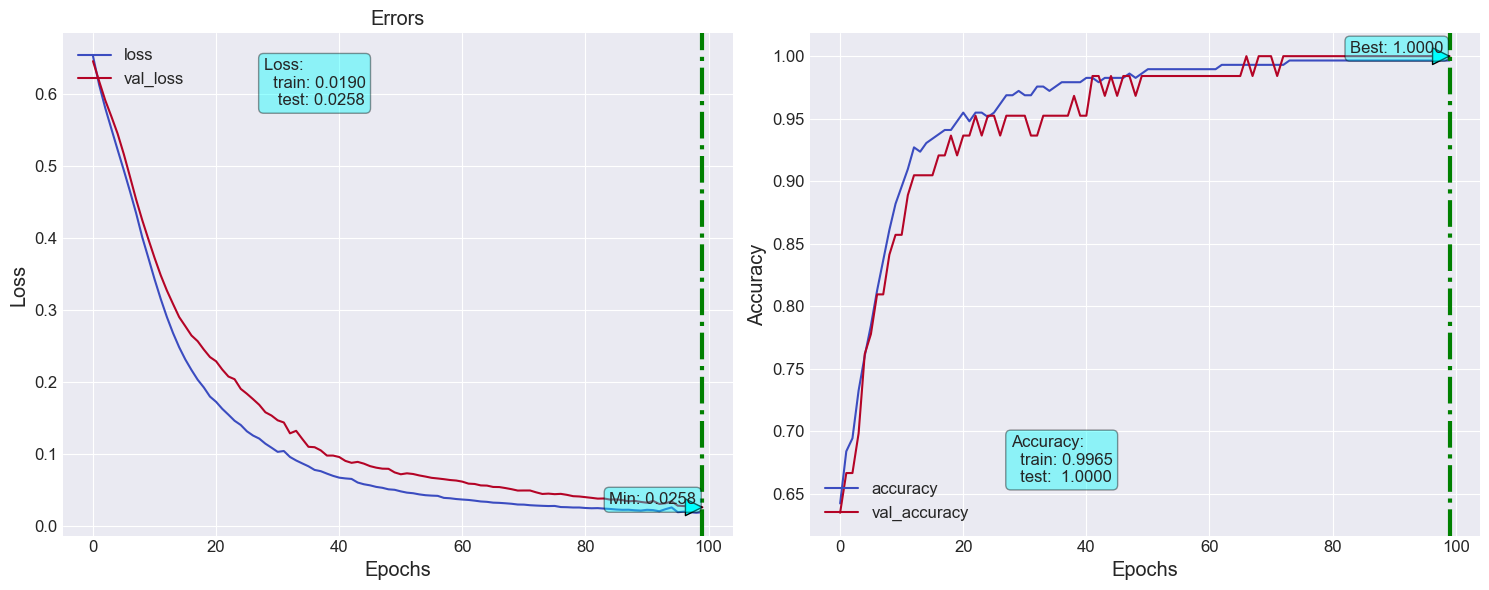

In [84]:
fn_plot_tf_hist(loss_df)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


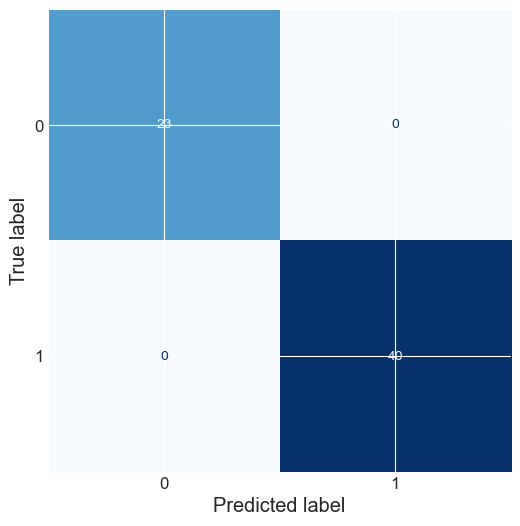

In [85]:
y_train_pred = model1.predict(X_train).argmax(axis=1)
y_test_pred= model1.predict(X_test).argmax(axis=1)
fig, ax= plt.subplots(figsize= (15,6))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap = 'Blues',ax=ax,colorbar=False)

In [56]:
f1_score(y_test, y_test_pred, average='weighted')

0.9840485988634137